<a href="https://colab.research.google.com/github/victorlf4/seri-mats-intrepretability-projects/blob/main/Notebooks/DecisionTransformersExperiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import plotly.io as pio

# Thanks to annoying rendering issues, Plotly graphics will either show up in colab OR Vscode depending on the renderer - this is bad for developing demos! Thus creating a debug mode.
pio.renderers.default = "colab"

In [2]:
!pip install git+https://github.com/neelnanda-io/Easy-Transformer.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/neelnanda-io/Easy-Transformer.git to /tmp/pip-req-build-yzf4cdol
  Running command git clone -q https://github.com/neelnanda-io/Easy-Transformer.git /tmp/pip-req-build-yzf4cdol
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 451 kB 12.3 MB/s 
     |████████████████████████████████| 1.9 MB 58.0 MB/s 
     |████████████████████████████████| 5.8 MB 17.2 MB/s 
     |████████████████████████████████| 41 kB 622 kB/s 
     |████████████████████████████████| 237 kB 67.5 MB/s 
     |████████████████████████████████| 182 kB 70.8 MB/s 
     |████████████████████████████████| 212 kB 77.0 MB/s 
     |████████████████████████████████| 132 kB 74.5 MB/s 
     |████████████████████████████████| 127 kB 80.2 MB/s 
     |████████████████████████████████| 51 kB 8.7

In [3]:
!git clone https://github.com/victorlf4/seri-mats-intrepretability-projects

Cloning into 'seri-mats-intrepretability-projects'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 21 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (21/21), done.


In [4]:
%%capture
!pip install gym[toy_text]
!pip install stable-baselines3

In [5]:
# from google.colab import drive
from pathlib import Path
import pickle
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1" #uncoment to debug

# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm

import random
import time
import matplotlib.pyplot as plt

%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go

from torch.utils.data import DataLoader

from functools import *
import pandas as pd
import gc
import collections
import copy

# import comet_ml
import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets

import gym

In [6]:
#To render the enviroments.
%%capture 
!pip install imageio==2.4.1
!apt-get install -y xvfb python-opengl ffmpeg 
!pip install -U colabgymrender
!pip install pyvirtualdisplay 
!pip install piglet

In [7]:
#from easy_transformer.utils import (gelu_new,to_numpy,get_corner,lm_cross_entropy_loss,)  # Helper functions
import easy_transformer.utils as utils
from easy_transformer.hook_points import (
  HookedRootModule,
  HookPoint,
)  # Hooking utilities
from easy_transformer import EasyTransformer, EasyTransformerConfig
import easy_transformer

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Some plotting code. Wrappers around Plotly, not important to understand.

In [9]:
def imshow(tensor, yaxis="", xaxis="", **kwargs):
  tensor = utils.to_numpy(tensor)
  plot_kwargs = {"color_continuous_scale":"RdBu", "color_continuous_midpoint":0.0, "labels":{"x":xaxis, "y":yaxis}}
  plot_kwargs.update(kwargs)
  px.imshow(tensor, **plot_kwargs).show()

#UTILS

In [10]:
def encode_sequence(batch):
   tensor = torch.as_tensor(batch,dtype=torch.long)
   return tensor.flatten(start_dim=1)


In [11]:
def gymEnvSample(env,model=None, batch_size=5, sequence_size=10,reward2go=False,renderize=False):#make non buggy versuion
  batch = []
  if renderize:
    env = Recorder(env, './video', fps=60)
  for i in range(batch_size):
    obs=env.reset()
    reward=0
    if(reward2go):
       totalReward=0
    steps = []#]TODO!!!!!! fix this
    for j in range(sequence_size):
      if model is not None:
        action = model.predict(obs)
        action=action[0].item()
      else:
        action = env.action_space.sample()
      steps.append([reward, obs, action])  
      obs, reward, done, info = env.step(action)
      if(reward2go):
        totalReward=totalReward+reward
      #if done:break #TODO pensar en como funcionan rewards
    if(reward2go):
      stepsRTG=[]
      r2go= totalReward;
      for step in steps:
        r2go= r2go - step[0]
        obs=step[1]
        action=step[2]
        stepsRTG.append([r2go, obs, action])
      batch.append(stepsRTG)
    else:
       batch.append(steps)
  if renderize:
    env.close()
    env.play()
  return encode_sequence(batch)

In [12]:
def array2text(array,firstElement=0,actionNames={},observationNames={},rewardNames={}):#TODo maybe make a readable option that ouputs each step in a row(but rememebr that this has to be togleable to not crash pyysvelte visualization)
  str_array=[]
  if isinstance(array, torch.Tensor):
    array=array.numpy()
  for i in range(len(array)):
     position = firstElement+i
     token_id=array[i]
     if position  % 3 == 0:
       if token_id in rewardNames:
         str_array.append(str(int(position/3))+"_R:"+rewardNames[token_id])
       else:
         str_array.append(str(int(position/3))+"_R:"+str(token_id))
     if position  % 3 == 1:    
        if token_id in observationNames:
         str_array.append(str(int(position/3))+"_O:"+observationNames[token_id])
        else:
          str_array.append(str(int(position/3))+"_O:"+str(token_id))
     if position  % 3 == 2:
        if token_id in actionNames:  
          str_array.append(str(int(position/3))+"_A:"+ actionNames[token_id])
        else:
          str_array.append(str(int(position/3))+"_A:"+str(token_id))    

  return str_array


In [13]:
def print_actions(array,firstElement=0,actionNames={}):#TODO make this an option in array2text alowing you to print watever you want.
  str_array=[]
  if isinstance(array, torch.Tensor):
    array=array.numpy()
  for i in range(len(array)):
     position = firstElement+i
     token_id=array[i]
     if position  % 3 == 2:
        if token_id in actionNames:  
          str_array.append(str(int(position/3))+"_A:"+ actionNames[token_id])
        else:
          str_array.append(str(int(position/3))+"_A:"+str(token_id))    

  return str_array

In [14]:
def array2textShifted(array,actionNames={},observationNames={},rewardNames={}):
   return array2text(array,firstElement=1,actionNames=actionNames,observationNames=observationNames,rewardNames=rewardNames)



In [16]:
def grid_names(num_rows=4,num_cols=4):
  pos=0
  observationNames={}
  for row in range(num_rows):
    for col in range(num_cols):
      observationNames[pos]="x"+str(col) +" y"+str(row)
      pos+=1
  return observationNames
print(grid_names())     

{0: 'x0 y0', 1: 'x1 y0', 2: 'x2 y0', 3: 'x3 y0', 4: 'x0 y1', 5: 'x1 y1', 6: 'x2 y1', 7: 'x3 y1', 8: 'x0 y2', 9: 'x1 y2', 10: 'x2 y2', 11: 'x3 y2', 12: 'x0 y3', 13: 'x1 y3', 14: 'x2 y3', 15: 'x3 y3'}


In [17]:
#action_names= {0 : "LEFT",1: "DOWN",2: "RIGH",3: "UP"}
action_names= {0 : "<--",
1: "DOWN",
2: "-->",
3: "UP"}
observation_names=grid_names()

##Plotting utils

In [18]:
def lines(lines_list, x=None, mode='lines', labels=None, xaxis='', yaxis='', title = '', log_y=False, hover=None, **kwargs):
    # Helper function to plot multiple lines
    if type(lines_list)==torch.Tensor:
        lines_list = [lines_list[i] for i in range(lines_list.shape[0])]
    if x is None:
        x=np.arange(len(lines_list[0]))
    fig = go.Figure(layout={'title':title})
    fig.update_xaxes(title=xaxis)
    fig.update_yaxes(title=yaxis)
    for c, line in enumerate(lines_list):
        if type(line)==torch.Tensor:
            line = utils.to_numpy(line)
        if labels is not None:
            label = labels[c]
        else:
            label = c
        fig.add_trace(go.Scatter(x=x, y=line, mode=mode, name=label, hovertext=hover, **kwargs))
    if log_y:
        fig.update_layout(yaxis_type="log")
    fig.show()

In [19]:
def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)


##Batch utils

In [20]:
def filter_batch(batch,initial_reward=None):
  filtered_batch=[]
  for sequence in batch:
    if (initial_reward is None) or sequence[0] == initial_reward: 
      filtered_batch.append(sequence)
  return torch.stack(filtered_batch)


#Training RLAgent

In [21]:
!git clone https://github.com/DLR-RM/rl-baselines3-zoo
!cd rl-baselines3-zoo/

Cloning into 'rl-baselines3-zoo'...
remote: Enumerating objects: 4597, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 4597 (delta 11), reused 23 (delta 6), pack-reused 4563
Receiving objects: 100% (4597/4597), 2.95 MiB | 21.12 MiB/s, done.
Resolving deltas: 100% (3031/3031), done.


In [22]:
def print_episode_info(locals, globals):
  # Print the observations, rewards, and actions for the current episode
  print(dir(locals['self']))
  print(locals['self'].obs)
  print(locals['self'].reward)
  print(locals['self'].action)

In [23]:
import gym

from stable_baselines3 import DQN
#from stable_baselines3.common.env_util import make_vec_env

#TODo look into using PPO
# Parallel environments
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False) 
rl_model = DQN("MlpPolicy", env, verbose=1)
#rl_model.learn(total_timesteps=100000)
#rl_model.learn(total_timesteps=100000 )
#gym.make("CartPole-v1")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [24]:
import gym

from stable_baselines3 import DQN
#from stable_baselines3.common.env_util import make_vec_env

#TODo look into using PPO
# Parallel environments
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False) 
rl_model = DQN("MlpPolicy", env, verbose=1)
#rl_model.learn(total_timesteps=100000)
#rl_model.learn(total_timesteps=100000 )

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [25]:
rl_model = DQN.load("./seri-mats-intrepretability-projects/Models/FreezingDQNModel1.zip")

In [26]:
obs = env.reset()

#while True:
test_rl_sequnce=[0,obs]
for i in range(60):
    action, _states = rl_model.predict(obs)
    action=action.item()
    obs, rewards, dones, info = env.step(action)
    test_rl_sequnce.append([action,rewards,obs])

    #env.render()
print(test_rl_sequnce)

[0, 0, [2, 0.0, 1], [2, 0.0, 2], [1, 0.0, 6], [1, 0.0, 10], [2, 0.0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11], [2, 0, 11]]


In [27]:
import datetime
now = datetime.datetime.now()
formatted_date = now.strftime("%A_%H:%M")
#rl_model.save("FreezingDQNModel"+formatted_date)

In [28]:
test_sequence_rl=gymEnvSample(env,model=rl_model,batch_size=10,sequence_size=16,reward2go=True,renderize=False)
print(test_sequence_rl[1:5])

tensor([[ 1,  0,  2,  1,  1,  2,  1,  2,  1,  1,  6,  1,  1, 10,  1,  1, 14,  2,
          0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,
          0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1],
        [ 1,  0,  2,  1,  1,  2,  1,  2,  1,  1,  6,  1,  1, 10,  1,  1, 14,  2,
          0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,
          0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1],
        [ 1,  0,  2,  1,  1,  2,  1,  2,  1,  1,  6,  1,  1, 10,  1,  1, 14,  2,
          0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,
          0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1],
        [ 1,  0,  2,  1,  1,  2,  1,  2,  1,  1,  6,  1,  1, 10,  1,  1, 14,  2,
          0, 15,  1,  0, 15,  1,  0, 15,  2,  0, 15,  1,  0, 15,  1,  0, 15,  1,
          0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1]])


<ipython-input-10-424fa371a3f5>:2: DeprecationWarning:

an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.



# Training the model

In [29]:
tiny_cfg = EasyTransformerConfig(
  d_model=128,
  d_head=128,
  n_heads=1,
  d_mlp=256,
  n_layers=1,
  n_ctx=60,
  act_fn="solu_ln",
  d_vocab=16,
  normalization_type="LN",
  seed=23,  # Now we're training a custom model, it's good to set the seed to get reproducible results. It defaults to 42.
)
tiny_model = EasyTransformer(tiny_cfg).to(device)

assert tiny_model.cfg.n_ctx % 3 == 0, "n_ctx must be divisible by 3"

Moving model to device:  cuda
Moving model to device:  cuda


In [30]:
tiny_optimizer = torch.optim.AdamW(tiny_model.parameters(), lr=1e-3,weight_decay=1e-4)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,lambda steps: min((steps+1)/10, 1))    
batch_size = 64
num_epochs = 500
#num_epochs = 1000

env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)

In [31]:
#TODO validation?

In [32]:
def getbatch(env,models,batch_size=batch_size,sequence_size=int(tiny_model.cfg.n_ctx / 3)):#maybe make n batches of random sizes and then mix them together.
    batch=[]
    for i in range (batch_size):
      model= random.choice(models)
      batch.append(gymEnvSample(env,model,batch_size=1,sequence_size=int(tiny_model.cfg.n_ctx / 3),reward2go=True,renderize=False))#Migth modify this to ouput a single batch by default instead so is less anoying.
    return torch.cat(batch)

In [33]:
def getbatchAD(env,models,batch_size=batch_size,sequence_size=int(tiny_model.cfg.n_ctx / 3)):#maybe make n batches of random sizes and then mix them together.
    batch=[]
    for i in range (batch_size):
      model= random.choice(models)
      batch.append(gymEnvSample(env,model,batch_size=1,sequence_size=int(tiny_model.cfg.n_ctx / 3),reward2go=True,renderize=False))#Migth modify this to ouput a single batch by default instead so is less anoying.
    return torch.cat(batch)

In [34]:
def train_model(model):
  losses = []
  random.seed(10)
  # TODO maybe use a learning rate scheduler
  #todo mayeb make a tran script to automate training.
  for epoch in tqdm.tqdm(range(num_epochs)):
    batch = getbatch(env,[None,rl_model],batch_size=batch_size,sequence_size=int(model.cfg.n_ctx / 3))
    loss = model(batch, return_type="loss")
    loss.backward()
    tiny_optimizer.step()
    tiny_optimizer.zero_grad()
    losses.append(loss.item())
    if epoch % 100 == 0:
      print(f"Epoch: {epoch}. Loss: {loss}")
  px.line(losses, labels={"x": "Epoch", "y": "Loss"})
  return losses
  


In [35]:
#losses = train_model(tiny_model)
#torch.save(tiny_model, "testDT"+formatted_date)
#px.line(losses, labels={"x": "Epoch", "y": "Loss"})

In [36]:
!ls
tiny_model =torch.load("./seri-mats-intrepretability-projects/Models/frozenLakeDT")

rl-baselines3-zoo  sample_data	seri-mats-intrepretability-projects


In [37]:
##model.eval()??

In [38]:
batch = getbatch(env,[None,rl_model],batch_size=batch_size,sequence_size=int(tiny_model.cfg.n_ctx / 3))
logits, tiny_cache = tiny_model.run_with_cache(batch)
print("Cache:", tiny_cache)

<ipython-input-10-424fa371a3f5>:2: DeprecationWarning:

an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.



Cache: ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_attn', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_mid', 'blocks.0.mlp.ln.hook_scale', 'blocks.0.mlp.ln.hook_normalized', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'ln_final.hook_scale', 'ln_final.hook_normalized']


In [39]:
test_batch = getbatch(env,[None,rl_model],batch_size=batch_size,sequence_size=int(tiny_model.cfg.n_ctx / 3))

<ipython-input-10-424fa371a3f5>:2: DeprecationWarning:

an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.



In [40]:
print(test_batch)

tensor([[ 0,  0,  2,  ...,  0,  7,  2],
        [ 1,  0,  2,  ...,  0, 15,  1],
        [ 0,  0,  3,  ...,  0,  5,  1],
        ...,
        [ 0,  0,  3,  ...,  0,  5,  2],
        [ 1,  0,  2,  ...,  0, 15,  1],
        [ 1,  0,  2,  ...,  0, 15,  1]])


#Testing model

##Plotting losses by poisition

In [41]:
batch_size = 10
seq_len = 60
random_tokens = torch.randint(0, 16, (batch_size, seq_len)).to(tiny_model.cfg.device)
print(random_tokens.size())
random_logits = tiny_model(random_tokens)
correct_log_probs = tiny_model.loss_fn(random_logits, random_tokens, per_token=True)
loss_by_position = einops.reduce(correct_log_probs, "batch position -> position", "mean")
line(loss_by_position, xaxis="Position", yaxis="Loss", title="Loss by position on random repeated tokens")

torch.Size([10, 60])


In [42]:
random_logits = tiny_model(test_batch)
correct_log_probs = tiny_model.loss_fn(random_logits.cpu(), test_batch, per_token=True)
loss_by_position = einops.reduce(correct_log_probs, "batch position -> position", "mean")
line(loss_by_position, xaxis="Position", yaxis="Loss", title="Loss by position of the test batch")

In [43]:
no_reward_batch=filter_batch(test_batch,initial_reward=0)
random_logits = tiny_model(no_reward_batch)
correct_log_probs = tiny_model.loss_fn(random_logits.cpu(), no_reward_batch, per_token=True)
loss_by_position = einops.reduce(correct_log_probs, "batch position -> position", "mean")
line(loss_by_position, xaxis="Position", yaxis="Loss", title="Loss by position of the test batch whith r2go 0")


In [44]:
no_reward_batch=filter_batch(test_batch,initial_reward=1)
random_logits = tiny_model(no_reward_batch)
correct_log_probs = tiny_model.loss_fn(random_logits.cpu(), no_reward_batch, per_token=True)
loss_by_position = einops.reduce(correct_log_probs, "batch position -> position", "mean")
line(loss_by_position, xaxis="Position", yaxis="Loss", title="Loss by position of the test batch, r2go 1")

#Generating tokens

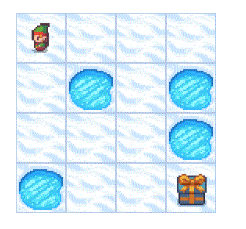

In [45]:
def testModel(input_tensor,verbose=True):
  with torch.no_grad():
    logit = tiny_model(input_tensor)
    ouput=np.argmax(logit.cpu().numpy(), axis=2)
    print("Input:")
    if(verbose):
     print(array2text(input_tensor,actionNames=action_names,observationNames=observation_names)[1:])
    else:
     print(input_tensor[1:].numpy()) 
    print("Ouptut:")
    if(verbose):
      print(array2textShifted(ouput[0],actionNames=action_names,observationNames=observation_names))
    else:
      print(ouput[0])

In [46]:
test_tensor=test_batch[0]
testModel(test_tensor,verbose=True)

Input:
['0_O:x0 y0', '0_A:-->', '1_R:0', '1_O:x1 y0', '1_A:UP', '2_R:0', '2_O:x1 y0', '2_A:-->', '3_R:0', '3_O:x2 y0', '3_A:DOWN', '4_R:0', '4_O:x2 y1', '4_A:DOWN', '5_R:0', '5_O:x2 y2', '5_A:DOWN', '6_R:0', '6_O:x2 y3', '6_A:DOWN', '7_R:0', '7_O:x2 y3', '7_A:DOWN', '8_R:0', '8_O:x2 y3', '8_A:DOWN', '9_R:0', '9_O:x2 y3', '9_A:DOWN', '10_R:0', '10_O:x2 y3', '10_A:UP', '11_R:0', '11_O:x2 y2', '11_A:UP', '12_R:0', '12_O:x2 y1', '12_A:-->', '13_R:0', '13_O:x3 y1', '13_A:-->', '14_R:0', '14_O:x3 y1', '14_A:DOWN', '15_R:0', '15_O:x3 y1', '15_A:DOWN', '16_R:0', '16_O:x3 y1', '16_A:UP', '17_R:0', '17_O:x3 y1', '17_A:DOWN', '18_R:0', '18_O:x3 y1', '18_A:<--', '19_R:0', '19_O:x3 y1', '19_A:-->']
Ouptut:
['0_O:x0 y0', '0_A:DOWN', '1_R:0', '1_O:x1 y0', '1_A:DOWN', '2_R:0', '2_O:x1 y0', '2_A:-->', '3_R:0', '3_O:x2 y0', '3_A:UP', '4_R:0', '4_O:x2 y1', '4_A:UP', '5_R:0', '5_O:x2 y2', '5_A:<--', '6_R:0', '6_O:x2 y3', '6_A:UP', '7_R:0', '7_O:x1 y3', '7_A:UP', '8_R:0', '8_O:x0 y0', '8_A:<--', '9_R:0', '

In [47]:
def ouputLogits(input_tensor,softmax=False):
  with torch.no_grad():
    logit = tiny_model(input_tensor)
    output=logit[0]
    if softmax:
     output= F.softmax(output,dim=-1)
    return output.cpu().numpy()

In [48]:
def generalteLabels(lenght,firstElement=0):#TODo maybe another for the other axis showing conflicting things
  str_array=[]
  for i in range(lenght):
     position = firstElement+i
     if position  % 3 == 0:
         str_array.append(f"R{i}")
     if position  % 3 == 1:    
         str_array.append(f"O{i}")
     if position  % 3 == 2:
         str_array.append(f"A{i}")    
  return str_array


In [49]:
winning_batch=filter_batch(test_batch,initial_reward=1)
print(winning_batch[0])
loosing_batch=filter_batch(test_batch,initial_reward=0)
print(loosing_batch[0])

tensor([ 1,  0,  2,  1,  1,  2,  1,  2,  1,  1,  6,  1,  1, 10,  1,  1, 14,  2,
         0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,
         0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,
         0, 15,  1,  0, 15,  1])
tensor([ 0,  0,  2,  0,  1,  3,  0,  1,  2,  0,  2,  1,  0,  6,  1,  0, 10,  1,
         0, 14,  1,  0, 14,  1,  0, 14,  1,  0, 14,  1,  0, 14,  3,  0, 10,  3,
         0,  6,  2,  0,  7,  2,  0,  7,  1,  0,  7,  1,  0,  7,  3,  0,  7,  1,
         0,  7,  0,  0,  7,  2])


In [50]:
probabilities=ouputLogits(winning_batch[0],softmax=True)
imshow(probabilities, title="Win sequence logits", height=1000, width=1000, xaxis="Token", yaxis="position")
print(array2text(winning_batch[0]))
probabilities=ouputLogits(loosing_batch[0],softmax=True)
imshow(probabilities, title="Lose sequence logits", height=1000, width=1000, xaxis="Token", yaxis="position")
print(array2text(loosing_batch[0]))

['0_R:1', '0_O:0', '0_A:2', '1_R:1', '1_O:1', '1_A:2', '2_R:1', '2_O:2', '2_A:1', '3_R:1', '3_O:6', '3_A:1', '4_R:1', '4_O:10', '4_A:1', '5_R:1', '5_O:14', '5_A:2', '6_R:0', '6_O:15', '6_A:1', '7_R:0', '7_O:15', '7_A:1', '8_R:0', '8_O:15', '8_A:1', '9_R:0', '9_O:15', '9_A:1', '10_R:0', '10_O:15', '10_A:1', '11_R:0', '11_O:15', '11_A:1', '12_R:0', '12_O:15', '12_A:1', '13_R:0', '13_O:15', '13_A:1', '14_R:0', '14_O:15', '14_A:1', '15_R:0', '15_O:15', '15_A:1', '16_R:0', '16_O:15', '16_A:1', '17_R:0', '17_O:15', '17_A:1', '18_R:0', '18_O:15', '18_A:1', '19_R:0', '19_O:15', '19_A:1']


['0_R:0', '0_O:0', '0_A:2', '1_R:0', '1_O:1', '1_A:3', '2_R:0', '2_O:1', '2_A:2', '3_R:0', '3_O:2', '3_A:1', '4_R:0', '4_O:6', '4_A:1', '5_R:0', '5_O:10', '5_A:1', '6_R:0', '6_O:14', '6_A:1', '7_R:0', '7_O:14', '7_A:1', '8_R:0', '8_O:14', '8_A:1', '9_R:0', '9_O:14', '9_A:1', '10_R:0', '10_O:14', '10_A:3', '11_R:0', '11_O:10', '11_A:3', '12_R:0', '12_O:6', '12_A:2', '13_R:0', '13_O:7', '13_A:2', '14_R:0', '14_O:7', '14_A:1', '15_R:0', '15_O:7', '15_A:1', '16_R:0', '16_O:7', '16_A:3', '17_R:0', '17_O:7', '17_A:1', '18_R:0', '18_O:7', '18_A:0', '19_R:0', '19_O:7', '19_A:2']


In [51]:
modified_sequence=torch.tensor([ 1,  0,  1,  1,  1,  2,  1,  2,  1,  1,  6,  1,  1, 10,  1,  1, 14,  2,0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,
         0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,0, 15,  1,  0, 15,  1])

probabilities=ouputLogits(modified_sequence,softmax=True)
imshow(probabilities, title="Test", height=1000, width=1000, xaxis="Token", yaxis="position")
print(array2text(modified_sequence))

['0_R:1', '0_O:0', '0_A:1', '1_R:1', '1_O:1', '1_A:2', '2_R:1', '2_O:2', '2_A:1', '3_R:1', '3_O:6', '3_A:1', '4_R:1', '4_O:10', '4_A:1', '5_R:1', '5_O:14', '5_A:2', '6_R:0', '6_O:15', '6_A:1', '7_R:0', '7_O:15', '7_A:1', '8_R:0', '8_O:15', '8_A:1', '9_R:0', '9_O:15', '9_A:1', '10_R:0', '10_O:15', '10_A:1', '11_R:0', '11_O:15', '11_A:1', '12_R:0', '12_O:15', '12_A:1', '13_R:0', '13_O:15', '13_A:1', '14_R:0', '14_O:15', '14_A:1', '15_R:0', '15_O:15', '15_A:1', '16_R:0', '16_O:15', '16_A:1', '17_R:0', '17_O:15', '17_A:1', '18_R:0', '18_O:15', '18_A:1', '19_R:0', '19_O:15', '19_A:1']


In [52]:
modified_sequence=torch.tensor([ 1,  0,  2,  1,  1,  2,  1,  2,  1,  1,  6,  1,  1, 10,  1,  1, 14,  2,0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,
         0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,0, 15,  1,  0, 15,  1])

probabilities=ouputLogits(modified_sequence,softmax=True)
imshow(probabilities, title="Test", height=1000, width=1000, xaxis="Token", yaxis="position")
print(array2text(modified_sequence))

['0_R:1', '0_O:0', '0_A:2', '1_R:1', '1_O:1', '1_A:2', '2_R:1', '2_O:2', '2_A:1', '3_R:1', '3_O:6', '3_A:1', '4_R:1', '4_O:10', '4_A:1', '5_R:1', '5_O:14', '5_A:2', '6_R:0', '6_O:15', '6_A:1', '7_R:0', '7_O:15', '7_A:1', '8_R:0', '8_O:15', '8_A:1', '9_R:0', '9_O:15', '9_A:1', '10_R:0', '10_O:15', '10_A:1', '11_R:0', '11_O:15', '11_A:1', '12_R:0', '12_O:15', '12_A:1', '13_R:0', '13_O:15', '13_A:1', '14_R:0', '14_O:15', '14_A:1', '15_R:0', '15_O:15', '15_A:1', '16_R:0', '16_O:15', '16_A:1', '17_R:0', '17_O:15', '17_A:1', '18_R:0', '18_O:15', '18_A:1', '19_R:0', '19_O:15', '19_A:1']


##Generate Sequences iteratively


In [53]:
def testModelIterative(input_tensor,iterations=1,print_iterations=False,verbose=False):
  with torch.no_grad():
    for i in range(iterations):
      logit = tiny_model(input_tensor)
      ouput=np.argmax(logit.cpu().numpy(), axis=2)
      if(print_iterations):
        print("Ouptut_iteration"+str(i)+":")
        if(verbose):
          print(array2text(input_tensor,actionNames=action_names,observationNames=observation_names))
        else:
          print(input_tensor)
      input_tensor=torch.cat((input_tensor,torch.tensor([ouput[0,-1]])))
  print("Full_Output"+":")
  if(verbose):
    print(array2text(input_tensor,actionNames=action_names,observationNames=observation_names))
  else:
    print(input_tensor)
  return input_tensor


In [54]:
def generateModelIterative(input_tensor,iterations=1,print_full=True,print_iterations=False,verbose=False):#TODO maybe make a variable in previous
  with torch.no_grad():
    for i in range(iterations):
      logit = tiny_model(input_tensor)
      ouput=np.argmax(logit.cpu().numpy(), axis=2)
      input_tensor=torch.cat((input_tensor,torch.tensor([ouput[0,-1]])))
  return input_tensor

In [55]:
testModelIterative(torch.as_tensor([1]),iterations=60,verbose=True)

Full_Output:
['0_R:1', '0_O:x0 y0', '0_A:DOWN', '1_R:1', '1_O:x0 y1', '1_A:DOWN', '2_R:1', '2_O:x0 y2', '2_A:-->', '3_R:1', '3_O:x1 y2', '3_A:-->', '4_R:1', '4_O:x2 y2', '4_A:DOWN', '5_R:1', '5_O:x2 y3', '5_A:-->', '6_R:0', '6_O:x3 y3', '6_A:DOWN', '7_R:0', '7_O:x3 y3', '7_A:DOWN', '8_R:0', '8_O:x3 y3', '8_A:DOWN', '9_R:0', '9_O:x3 y3', '9_A:DOWN', '10_R:0', '10_O:x3 y3', '10_A:DOWN', '11_R:0', '11_O:x3 y3', '11_A:DOWN', '12_R:0', '12_O:x3 y3', '12_A:DOWN', '13_R:0', '13_O:x3 y3', '13_A:DOWN', '14_R:0', '14_O:x3 y3', '14_A:DOWN', '15_R:0', '15_O:x3 y3', '15_A:DOWN', '16_R:0', '16_O:x3 y3', '16_A:DOWN', '17_R:0', '17_O:x3 y3', '17_A:DOWN', '18_R:0', '18_O:x3 y3', '18_A:DOWN', '19_R:0', '19_O:x3 y3', '19_A:DOWN', '20_R:0']


tensor([ 1,  0,  1,  1,  4,  1,  1,  8,  2,  1,  9,  2,  1, 10,  1,  1, 14,  2,
         0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,
         0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,
         0, 15,  1,  0, 15,  1,  0])

In [56]:
testModelIterative(torch.as_tensor([0]),iterations=60,verbose=True)

Full_Output:
['0_R:0', '0_O:x0 y0', '0_A:DOWN', '1_R:0', '1_O:x0 y1', '1_A:DOWN', '2_R:0', '2_O:x0 y2', '2_A:-->', '3_R:0', '3_O:x1 y2', '3_A:-->', '4_R:0', '4_O:x2 y2', '4_A:UP', '5_R:0', '5_O:x2 y1', '5_A:<--', '6_R:0', '6_O:x1 y1', '6_A:DOWN', '7_R:0', '7_O:x1 y1', '7_A:DOWN', '8_R:0', '8_O:x1 y1', '8_A:DOWN', '9_R:0', '9_O:x1 y1', '9_A:DOWN', '10_R:0', '10_O:x1 y1', '10_A:DOWN', '11_R:0', '11_O:x1 y1', '11_A:DOWN', '12_R:0', '12_O:x1 y1', '12_A:DOWN', '13_R:0', '13_O:x1 y1', '13_A:DOWN', '14_R:0', '14_O:x1 y1', '14_A:DOWN', '15_R:0', '15_O:x1 y1', '15_A:DOWN', '16_R:0', '16_O:x1 y1', '16_A:DOWN', '17_R:0', '17_O:x1 y1', '17_A:DOWN', '18_R:0', '18_O:x1 y1', '18_A:DOWN', '19_R:0', '19_O:x1 y1', '19_A:DOWN', '20_R:5']


tensor([ 0,  0,  1,  0,  4,  1,  0,  8,  2,  0,  9,  2,  0, 10,  3,  0,  6,  0,
         0,  5,  1,  0,  5,  1,  0,  5,  1,  0,  5,  1,  0,  5,  1,  0,  5,  1,
         0,  5,  1,  0,  5,  1,  0,  5,  1,  0,  5,  1,  0,  5,  1,  0,  5,  1,
         0,  5,  1,  0,  5,  1,  5])

In [57]:
down_sequence=testModelIterative(torch.as_tensor([ 1,  0,  1]),iterations=57,verbose=True)
print(down_sequence)
print_actions(down_sequence,actionNames=action_names)

Full_Output:
['0_R:1', '0_O:x0 y0', '0_A:DOWN', '1_R:1', '1_O:x0 y1', '1_A:DOWN', '2_R:1', '2_O:x0 y2', '2_A:-->', '3_R:1', '3_O:x1 y2', '3_A:-->', '4_R:1', '4_O:x2 y2', '4_A:DOWN', '5_R:1', '5_O:x2 y3', '5_A:-->', '6_R:0', '6_O:x3 y3', '6_A:DOWN', '7_R:0', '7_O:x3 y3', '7_A:DOWN', '8_R:0', '8_O:x3 y3', '8_A:DOWN', '9_R:0', '9_O:x3 y3', '9_A:DOWN', '10_R:0', '10_O:x3 y3', '10_A:DOWN', '11_R:0', '11_O:x3 y3', '11_A:DOWN', '12_R:0', '12_O:x3 y3', '12_A:DOWN', '13_R:0', '13_O:x3 y3', '13_A:DOWN', '14_R:0', '14_O:x3 y3', '14_A:DOWN', '15_R:0', '15_O:x3 y3', '15_A:DOWN', '16_R:0', '16_O:x3 y3', '16_A:DOWN', '17_R:0', '17_O:x3 y3', '17_A:DOWN', '18_R:0', '18_O:x3 y3', '18_A:DOWN', '19_R:0', '19_O:x3 y3', '19_A:DOWN']
tensor([ 1,  0,  1,  1,  4,  1,  1,  8,  2,  1,  9,  2,  1, 10,  1,  1, 14,  2,
         0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,
         0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,
         0, 15,  1,  0, 15,  1])


['0_A:DOWN',
 '1_A:DOWN',
 '2_A:-->',
 '3_A:-->',
 '4_A:DOWN',
 '5_A:-->',
 '6_A:DOWN',
 '7_A:DOWN',
 '8_A:DOWN',
 '9_A:DOWN',
 '10_A:DOWN',
 '11_A:DOWN',
 '12_A:DOWN',
 '13_A:DOWN',
 '14_A:DOWN',
 '15_A:DOWN',
 '16_A:DOWN',
 '17_A:DOWN',
 '18_A:DOWN',
 '19_A:DOWN']

In [60]:
probabilities=ouputLogits(down_sequence,softmax=True)
imshow(probabilities, title="down_sequence predicted logits", height=1000, width=1000, xaxis="Token", yaxis="position")
print(array2text(down_sequence))

['0_R:1', '0_O:0', '0_A:1', '1_R:1', '1_O:4', '1_A:1', '2_R:1', '2_O:8', '2_A:2', '3_R:1', '3_O:9', '3_A:2', '4_R:1', '4_O:10', '4_A:1', '5_R:1', '5_O:14', '5_A:2', '6_R:0', '6_O:15', '6_A:1', '7_R:0', '7_O:15', '7_A:1', '8_R:0', '8_O:15', '8_A:1', '9_R:0', '9_O:15', '9_A:1', '10_R:0', '10_O:15', '10_A:1', '11_R:0', '11_O:15', '11_A:1', '12_R:0', '12_O:15', '12_A:1', '13_R:0', '13_O:15', '13_A:1', '14_R:0', '14_O:15', '14_A:1', '15_R:0', '15_O:15', '15_A:1', '16_R:0', '16_O:15', '16_A:1', '17_R:0', '17_O:15', '17_A:1', '18_R:0', '18_O:15', '18_A:1', '19_R:0', '19_O:15', '19_A:1']


In [61]:
with torch.no_grad(): 
  input = torch.as_tensor(batch)
  logit = tiny_model(input)
  ouput=np.argmax(logit.cpu().numpy(), axis=2)
  print(array2text(batch[0],actionNames=action_names,observationNames=observation_names)[1:])
  print(array2textShifted(ouput[0],actionNames=action_names,observationNames=observation_names))

['0_O:x0 y0', '0_A:-->', '1_R:1', '1_O:x1 y0', '1_A:-->', '2_R:1', '2_O:x2 y0', '2_A:DOWN', '3_R:1', '3_O:x2 y1', '3_A:DOWN', '4_R:1', '4_O:x2 y2', '4_A:DOWN', '5_R:1', '5_O:x2 y3', '5_A:-->', '6_R:0', '6_O:x3 y3', '6_A:DOWN', '7_R:0', '7_O:x3 y3', '7_A:DOWN', '8_R:0', '8_O:x3 y3', '8_A:DOWN', '9_R:0', '9_O:x3 y3', '9_A:DOWN', '10_R:0', '10_O:x3 y3', '10_A:UP', '11_R:0', '11_O:x3 y3', '11_A:DOWN', '12_R:0', '12_O:x3 y3', '12_A:DOWN', '13_R:0', '13_O:x3 y3', '13_A:DOWN', '14_R:0', '14_O:x3 y3', '14_A:DOWN', '15_R:0', '15_O:x3 y3', '15_A:DOWN', '16_R:0', '16_O:x3 y3', '16_A:DOWN', '17_R:0', '17_O:x3 y3', '17_A:DOWN', '18_R:0', '18_O:x3 y3', '18_A:DOWN', '19_R:0', '19_O:x3 y3', '19_A:DOWN']
['0_O:x0 y0', '0_A:DOWN', '1_R:1', '1_O:x1 y0', '1_A:-->', '2_R:1', '2_O:x2 y0', '2_A:DOWN', '3_R:1', '3_O:x2 y1', '3_A:DOWN', '4_R:1', '4_O:x2 y2', '4_A:DOWN', '5_R:1', '5_O:x2 y3', '5_A:-->', '6_R:0', '6_O:x3 y3', '6_A:DOWN', '7_R:0', '7_O:x3 y3', '7_A:DOWN', '8_R:0', '8_O:x3 y3', '8_A:DOWN', '9_R:0'

In [62]:
with torch.no_grad():
  for i in range(5):
    random_tokens = torch.as_tensor(np.random.randint(10, size=30))
    testModel(random_tokens)
    

Input:
['0_O:x0 y0', '0_A:8', '1_R:0', '1_O:x0 y2', '1_A:<--', '2_R:4', '2_O:x3 y1', '2_A:4', '3_R:2', '3_O:x0 y0', '3_A:5', '4_R:2', '4_O:x0 y0', '4_A:8', '5_R:6', '5_O:x2 y1', '5_A:<--', '6_R:3', '6_O:x1 y2', '6_A:UP', '7_R:1', '7_O:x0 y1', '7_A:4', '8_R:2', '8_O:x1 y1', '8_A:UP', '9_R:0', '9_O:x0 y2', '9_A:<--']
Ouptut:
['0_O:x3 y1', '0_A:7', '1_R:7', '1_O:x0 y2', '1_A:DOWN', '2_R:0', '2_O:x0 y2', '2_A:DOWN', '3_R:0', '3_O:x0 y1', '3_A:UP', '4_R:0', '4_O:x3 y1', '4_A:UP', '5_R:0', '5_O:x0 y1', '5_A:UP', '6_R:0', '6_O:x1 y1', '6_A:UP', '7_R:0', '7_O:x1 y1', '7_A:-->', '8_R:0', '8_O:x0 y2', '8_A:<--', '9_R:0', '9_O:x1 y1', '9_A:-->', '10_R:0']
Input:
['0_O:x1 y0', '0_A:6', '1_R:1', '1_O:x0 y1', '1_A:8', '2_R:0', '2_O:x0 y1', '2_A:UP', '3_R:9', '3_O:x3 y0', '3_A:<--', '4_R:3', '4_O:x1 y0', '4_A:DOWN', '5_R:7', '5_O:x2 y1', '5_A:5', '6_R:0', '6_O:x3 y0', '6_A:6', '7_R:4', '7_O:x1 y0', '7_A:9', '8_R:3', '8_O:x3 y1', '8_A:UP', '9_R:7', '9_O:x3 y0', '9_A:9']
Ouptut:
['0_O:x3 y0', '0_A:UP',

In [63]:
with torch.no_grad():
  for i in range(5):
    random_tokens = torch.as_tensor(np.random.randint(10, size=6))
    testModel(random_tokens)
  

Input:
['0_O:x1 y1', '0_A:6', '1_R:8', '1_O:x2 y0', '1_A:4']
Ouptut:
['0_O:x2 y2', '0_A:DOWN', '1_R:10', '1_O:x1 y1', '1_A:DOWN', '2_R:5']
Input:
['0_O:x3 y0', '0_A:9', '1_R:2', '1_O:x3 y1', '1_A:9']
Ouptut:
['0_O:x0 y0', '0_A:<--', '1_R:0', '1_O:x0 y2', '1_A:UP', '2_R:0']
Input:
['0_O:x3 y0', '0_A:5', '1_R:9', '1_O:x1 y1', '1_A:-->']
Ouptut:
['0_O:x0 y0', '0_A:DOWN', '1_R:0', '1_O:x1 y3', '1_A:DOWN', '2_R:1']
Input:
['0_O:x0 y1', '0_A:<--', '1_R:4', '1_O:x0 y2', '1_A:5']
Ouptut:
['0_O:x3 y0', '0_A:UP', '1_R:3', '1_O:x0 y0', '1_A:UP', '2_R:0']
Input:
['0_O:x0 y1', '0_A:-->', '1_R:2', '1_O:x1 y2', '1_A:4']
Ouptut:
['0_O:x0 y0', '0_A:5', '1_R:0', '1_O:x1 y0', '1_A:UP', '2_R:5']


#Playing

In [64]:
def gymEnvTransformer(env,model,max_step=10,reward2go=None,renderize=False, fps=60):
  if renderize:
     env = Recorder(env, './video', fps=fps)   
  obs=env.reset()
  steps=[0,obs]#Something weird about this
  if reward2go is not None:
    steps[0]= reward2go


  for j in range(max_step):
    np.argmax(logit.cpu().numpy(), axis=2)#TODO maybe sample probability instead
    actionlogits = model(encode_sequence([steps]))
    action=np.argmax(actionlogits.cpu().numpy(), axis=2)[0,-1]
    steps.append(action)
    obs, reward, done, info = env.step(action)

    if reward2go is not None:
      reward2go=reward2go-reward#TODO this migth crash if rtgo goes to 0
      steps.append(reward2go)
    else:
      steps.append(reward)
    steps.append(obs)
  if renderize:
    env.close()
    env.play()
  return steps

In [66]:
with torch.no_grad():
    test_play_sequence=gymEnvTransformer(env,tiny_model,max_step=20,reward2go=0)#,render=True
print(array2text(test_play_sequence,actionNames=action_names,observationNames=observation_names))
print_actions(test_play_sequence, actionNames=action_names)

['0_R:0', '0_O:x0 y0', '0_A:DOWN', '1_R:0.0', '1_O:x0 y1', '1_A:DOWN', '2_R:0.0', '2_O:x0 y2', '2_A:-->', '3_R:0.0', '3_O:x1 y2', '3_A:-->', '4_R:0.0', '4_O:x2 y2', '4_A:UP', '5_R:0.0', '5_O:x2 y1', '5_A:<--', '6_R:0.0', '6_O:x1 y1', '6_A:DOWN', '7_R:0.0', '7_O:x1 y1', '7_A:DOWN', '8_R:0.0', '8_O:x1 y1', '8_A:DOWN', '9_R:0.0', '9_O:x1 y1', '9_A:DOWN', '10_R:0.0', '10_O:x1 y1', '10_A:DOWN', '11_R:0.0', '11_O:x1 y1', '11_A:DOWN', '12_R:0.0', '12_O:x1 y1', '12_A:DOWN', '13_R:0.0', '13_O:x1 y1', '13_A:DOWN', '14_R:0.0', '14_O:x1 y1', '14_A:DOWN', '15_R:0.0', '15_O:x1 y1', '15_A:DOWN', '16_R:0.0', '16_O:x1 y1', '16_A:DOWN', '17_R:0.0', '17_O:x1 y1', '17_A:DOWN', '18_R:0.0', '18_O:x1 y1', '18_A:DOWN', '19_R:0.0', '19_O:x1 y1', '19_A:DOWN', '20_R:0.0', '20_O:x1 y1']


<ipython-input-10-424fa371a3f5>:2: DeprecationWarning:

an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.



['0_A:DOWN',
 '1_A:DOWN',
 '2_A:-->',
 '3_A:-->',
 '4_A:UP',
 '5_A:<--',
 '6_A:DOWN',
 '7_A:DOWN',
 '8_A:DOWN',
 '9_A:DOWN',
 '10_A:DOWN',
 '11_A:DOWN',
 '12_A:DOWN',
 '13_A:DOWN',
 '14_A:DOWN',
 '15_A:DOWN',
 '16_A:DOWN',
 '17_A:DOWN',
 '18_A:DOWN',
 '19_A:DOWN']

#Visualising attention patterns

In [67]:
for layer in range(tiny_model.cfg.n_layers):
  for head in range(tiny_model.cfg.n_heads):
    imshow(utils.to_numpy(tiny_cache[f'blocks.{layer}.attn.hook_attn'].mean(0)[head]), title=f'Layer {layer} Attention Pattern, Head {head}', height=500, width=500, xaxis="Token", yaxis="Activation")

In [68]:
%%capture
# Install an older version of node, so that Svelte works (a web dev framework)
!curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
!pip install git+https://github.com/neelnanda-io/PySvelte.git
import sys
sys.path.append('/content/PySvelte')

In [69]:
def cache_model(test_tokens):#TODO use model as imput
  with torch.no_grad():
    test_tokens_str=array2text(test_tokens,actionNames=action_names,observationNames=observation_names)
    logits, tiny_cache = tiny_model.run_with_cache(test_tokens)
    highest_logit = np.argmax(logits.cpu().numpy(), axis=2)
    print(f"Output tokens:{highest_logit}") 
    return test_tokens_str,logits, tiny_cache


In [70]:
import pysvelte
def attention_visualization(model):
  for layer in range(model.cfg.n_layers):
    print("Attention for layer", layer)
    print(tiny_cache[f'blocks.{layer}.attn.hook_attn'][0].shape)
    pysvelte.AttentionMulti(attention=tiny_cache[f'blocks.{layer}.attn.hook_attn'][0].permute(1, 2, 0),tokens=test_tokens_str).show() #.attn.hook_attn']

In [71]:
print(test_batch[4])

tensor([0, 0, 2, 0, 1, 3, 0, 1, 2, 0, 2, 3, 0, 2, 3, 0, 2, 0, 0, 1, 1, 0, 5, 2,
        0, 5, 0, 0, 5, 3, 0, 5, 3, 0, 5, 2, 0, 5, 1, 0, 5, 0, 0, 5, 2, 0, 5, 3,
        0, 5, 1, 0, 5, 2, 0, 5, 1, 0, 5, 3])


In [122]:
#test_tokens=torch.as_tensor(test_batch[6])#
test_tokens=torch.as_tensor([ 1,  0,  2,  1,  1,  2,  1,  2,  1,  1,  6,  1,  1, 10,  1,  1, 14,  2,
         0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  3,  0, 15,  1,
         0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,
         0, 15,  1,  0, 15,  1])
test_tokens_str,logits, tiny_cache=cache_model(test_tokens)
attention_visualization(tiny_model)

Output tokens:[[ 0  1  1  1  2  1  2  1  1  6  1  1 10  1  1 14  2  0 15  1  0 15  1  0
  15  1  0 15  1  0 15  1  0 15  1  0 15  1  0 15  1  0 15  1  0 15  1  0
  15  1  0 15  1  0 15  1  0 15  1  0]]
Attention for layer 0
torch.Size([1, 60, 60])


In [73]:
#TODO make function to do this more easily
for i in reversed(range(16)):
  attention_score=tiny_cache[f'blocks.{layer}.attn.hook_attn'][0].permute(1, 2, 0)[17*3,i*3+1]#[source target]
  print(f'Step{str(i).zfill(2)} Attention_Score={attention_score.item():.4f}')

Step15 Attention_Score=0.0219
Step14 Attention_Score=0.0361
Step13 Attention_Score=0.0231
Step12 Attention_Score=0.0122
Step11 Attention_Score=0.0187
Step10 Attention_Score=0.0194
Step09 Attention_Score=0.0067
Step08 Attention_Score=0.0061
Step07 Attention_Score=0.0030
Step06 Attention_Score=0.0094
Step05 Attention_Score=0.0027
Step04 Attention_Score=0.0013
Step03 Attention_Score=0.0032
Step02 Attention_Score=0.0005
Step01 Attention_Score=0.0006
Step00 Attention_Score=0.0012


In [74]:
#TODO make function to do this more easily
for i in range(16):
  attention_score=tiny_cache[f'blocks.{layer}.attn.hook_attn'][0].permute(1, 2, 0)[i*3+1,0*3+1]#[source target]
  print(f'Step{str(i).zfill(2)} Attention_Score={attention_score.item():.4f}')

Step00 Attention_Score=0.8454
Step01 Attention_Score=0.3223
Step02 Attention_Score=0.4554
Step03 Attention_Score=0.3778
Step04 Attention_Score=0.3635
Step05 Attention_Score=0.0185
Step06 Attention_Score=0.0225
Step07 Attention_Score=0.0146
Step08 Attention_Score=0.3715
Step09 Attention_Score=0.4331
Step10 Attention_Score=0.4991
Step11 Attention_Score=0.5036
Step12 Attention_Score=0.4167
Step13 Attention_Score=0.3936
Step14 Attention_Score=0.4097
Step15 Attention_Score=0.4081


In [78]:
print(test_batch[4])
print(test_batch[4][9])

tensor([0, 0, 2, 0, 1, 3, 0, 1, 2, 0, 2, 3, 0, 2, 3, 0, 2, 0, 0, 1, 1, 0, 5, 2,
        0, 5, 0, 0, 5, 3, 0, 5, 3, 0, 5, 2, 0, 5, 1, 0, 5, 0, 0, 5, 2, 0, 5, 3,
        0, 5, 1, 0, 5, 2, 0, 5, 1, 0, 5, 3])
tensor(0)


In [79]:
print(test_batch[6])

tensor([ 1,  0,  2,  1,  1,  2,  1,  2,  1,  1,  6,  1,  1, 10,  1,  1, 14,  0,
         1, 13,  2,  1, 14,  2,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,
         0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,
         0, 15,  0,  0, 15,  1])


#Ablating layers

##Ablating layers utils

In [80]:
def get_logit_probability(logits,position,token):
    return F.softmax(logits,dim=-1)[0, position, token]#Tbatch,position,token
example_tokens_tensor= torch.tensor(test_batch[6])    
example_logits = tiny_model(example_tokens_tensor) # Shape batch x position x vocab
example_logit_prob = get_logit_probability(example_logits,59,0)
print(f"Input text: {test_batch[6]}, : {example_logit_prob.item()}") 

Input text: tensor([ 1,  0,  2,  1,  1,  2,  1,  2,  1,  1,  6,  1,  1, 10,  1,  1, 14,  0,
         1, 13,  2,  1, 14,  2,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,
         0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,
         0, 15,  0,  0, 15,  1]), : 0.9106685519218445


<ipython-input-80-7d7abb1a5b7f>:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [169]:
def get_logit_probabilities(logits,position):
    return F.softmax(logits,dim=-1)[0, position]#Tbatch,position,token
example_tokens_tensor= torch.tensor(test_batch[6])    
example_logits = tiny_model(example_tokens_tensor) # Shape batch x position x vocab
example_logit_prob = get_logit_probabilities(example_logits,59)
print(f"Input text: {test_batch[6]}, : {example_logit_prob}") 

Input text: tensor([ 1,  0,  2,  1,  1,  2,  1,  2,  1,  1,  6,  1,  1, 10,  1,  1, 14,  0,
         1, 13,  2,  1, 14,  2,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,
         0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,
         0, 15,  0,  0, 15,  1]), : tensor([9.1067e-01, 6.6763e-04, 9.1927e-05, 2.1914e-04, 3.4014e-04, 2.0916e-05,
        6.4078e-04, 1.9355e-04, 1.0119e-04, 4.7946e-05, 2.7899e-05, 3.9013e-05,
        2.1290e-04, 1.3236e-04, 1.7128e-05, 8.6579e-02], device='cuda:0',
       grad_fn=<SelectBackward0>)


<ipython-input-169-fc3d3de7dd4d>:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [194]:
#TODO make code to ablate layers and test result of an arbitrary function
def ablate_layer_hook(layer_out, hook):
    layer_out[:] = 0.
    return layer_out
def ablate_layers_probability(position,token):
  attn_ablation = []
  example_tokens_tensor= torch.tensor(tokens_test)
  example_logits = tiny_model(example_tokens_tensor) # Shape batch x position x vocab
  example_logit_prob = get_logit_probability(example_logits,position,token)
  for layer in range(tiny_model.cfg.n_layers):
      logits = tiny_model.run_with_hooks(example_tokens_tensor, fwd_hooks=[(f"blocks.{layer}.hook_attn_out", ablate_layer_hook)])
      ablated_logit_prob = get_logit_probability(logits,position,token)
      change_in_logit_prob = ablated_logit_prob - example_logit_prob #Negative = strong effect
      attn_ablation.append((change_in_logit_prob.item()))
  mlp_ablation = []
  for layer in range(tiny_model.cfg.n_layers):
      logits = tiny_model.run_with_hooks(example_tokens_tensor, fwd_hooks=[(f"blocks.{layer}.hook_mlp_out", ablate_layer_hook)])
      ablated_logit_prob = get_logit_probability(logits,position,token)
      change_in_logit_prob = ablated_logit_prob - example_logit_prob #Negative = strong effect
      mlp_ablation.append((change_in_logit_prob.item()))
  #lines([attn_ablation, mlp_ablation], labels=['attn', 'mlp'], title='Layer Ablations', yaxis='Change in logit_prob', xaxis='Layer')
  return example_logits,attn_ablation ,mlp_ablation





In [ ]:
def ablate_layers_probability_all_tokens(position):
  attn_ablation = []
  example_tokens_tensor= torch.tensor(tokens_test)
  example_logits = tiny_model(example_tokens_tensor) # Shape batch x position x vocab
  example_logit_prob = get_logit_probabilities(example_logits,position)
  for layer in range(tiny_model.cfg.n_layers):
      logits = tiny_model.run_with_hooks(example_tokens_tensor, fwd_hooks=[(f"blocks.{layer}.hook_attn_out", ablate_layer_hook)])
      ablated_logit_prob = get_logit_probabilities(logits,position)
      change_in_logit_prob = ablated_logit_prob - example_logit_prob #Negative = strong effect
      attn_ablation.append((change_in_logit_prob))
  mlp_ablation = []
  for layer in range(tiny_model.cfg.n_layers):
      logits = tiny_model.run_with_hooks(example_tokens_tensor, fwd_hooks=[(f"blocks.{layer}.hook_mlp_out", ablate_layer_hook)])
      ablated_logit_prob = get_logit_probabilities(logits,position)
      change_in_logit_prob = ablated_logit_prob - example_logit_prob #Negative = strong effect
      mlp_ablation.append((change_in_logit_prob))
  #lines([attn_ablation, mlp_ablation], labels=['attn', 'mlp'], title='Layer Ablations', yaxis='Change in logit_prob', xaxis='Layer')
  return example_logits,attn_ablation ,mlp_ablation


In [ ]:
def ablate_block_logits():
  ablation_logits = []
  example_tokens_tensor= torch.tensor(tokens_test)
  example_logits = tiny_model(example_tokens_tensor) # Shape batch x position x vocab
  for layer in range(tiny_model.cfg.n_layers):
      ablated_logit = tiny_model.run_with_hooks(example_tokens_tensor, fwd_hooks=[(f"blocks.{layer}.hook_attn_out", ablate_layer_hook),(f"blocks.{layer}.hook_mlp_out", ablate_layer_hook)])
      ablation_logits.append(ablated_logit)
  #lines([attn_ablation, mlp_ablation], labels=['attn', 'mlp'], title='Layer Ablations', yaxis='Change in logit_prob', xaxis='Layer')
  return example_logits,ablation_logits 


In [203]:
def ablate_layers_logits():
  attn_ablation_logits = []
  example_tokens_tensor= torch.tensor(tokens_test)
  example_logits = tiny_model(example_tokens_tensor) # Shape batch x position x vocab
  for layer in range(tiny_model.cfg.n_layers):
      ablated_logit = tiny_model.run_with_hooks(example_tokens_tensor, fwd_hooks=[(f"blocks.{layer}.hook_attn_out", ablate_layer_hook)])
      attn_ablation_logits.append(ablated_logit)
  mlp_ablation_logits = []
  for layer in range(tiny_model.cfg.n_layers):
      logits = tiny_model.run_with_hooks(example_tokens_tensor, fwd_hooks=[(f"blocks.{layer}.hook_mlp_out", ablate_layer_hook)])
      mlp_ablation_logits.append(logits)
  #lines([attn_ablation, mlp_ablation], labels=['attn', 'mlp'], title='Layer Ablations', yaxis='Change in logit_prob', xaxis='Layer')
  return example_logits,attn_ablation_logits ,mlp_ablation_logits

In [197]:
def plot_ablation(position,token):
  example_logits,attn_ablation,mlp_ablation= ablate_layers_probability(position,token)
  imshow([example_logits[0][position].detach().cpu().numpy()],yaxis='token',title=f'logits at that position {position}')
  print("attention ablation:" +str(attn_ablation))
  print("mlp ablation:"+str(mlp_ablation))
  #To plot 1l 1h models better
  imshow([mlp_ablation,attn_ablation], yaxis='Layer',title=f'Effect of ablating layers on position {position} token:{token}',y=["mlp1","attention1"])
  

In [208]:
def plot_ablation_all_tokens(position):
  example_logits,attn_ablation,mlp_ablation= ablate_layers_probability_all_tokens(position)
  imshow([example_logits[0][position].detach().cpu().numpy()],yaxis='token',title=f'logits at that position {position}')
  #To plot 1l 1h models better
  array2text()
  imshow([mlp_ablation[0].detach().cpu().numpy(),attn_ablation[0].detach().cpu().numpy()], yaxis='Layer',title=f'Effect of ablating layers on position {position} token:{token}',y=["mlp1","attention1"])
  



In [209]:
plot_ablation_all_tokens(59)

<ipython-input-194-4dc6b5985bed>:26: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [123]:
tokens_test=torch.tensor([ 1,  0,  2,  1,  1,  2,  1,  2,  1,  1,  6,  1,  1, 10,  1,  1, 14,  2,
         0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  3,  0, 15,  1,
         0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,
         0, 15,  1,  0, 15,  1])
print(array2text(tokens_test,actionNames=action_names,observationNames=observation_names))

['0_R:1', '0_O:x0 y0', '0_A:-->', '1_R:1', '1_O:x1 y0', '1_A:-->', '2_R:1', '2_O:x2 y0', '2_A:DOWN', '3_R:1', '3_O:x2 y1', '3_A:DOWN', '4_R:1', '4_O:x2 y2', '4_A:DOWN', '5_R:1', '5_O:x2 y3', '5_A:-->', '6_R:0', '6_O:x3 y3', '6_A:DOWN', '7_R:0', '7_O:x3 y3', '7_A:DOWN', '8_R:0', '8_O:x3 y3', '8_A:DOWN', '9_R:0', '9_O:x3 y3', '9_A:DOWN', '10_R:0', '10_O:x3 y3', '10_A:UP', '11_R:0', '11_O:x3 y3', '11_A:DOWN', '12_R:0', '12_O:x3 y3', '12_A:DOWN', '13_R:0', '13_O:x3 y3', '13_A:DOWN', '14_R:0', '14_O:x3 y3', '14_A:DOWN', '15_R:0', '15_O:x3 y3', '15_A:DOWN', '16_R:0', '16_O:x3 y3', '16_A:DOWN', '17_R:0', '17_O:x3 y3', '17_A:DOWN', '18_R:0', '18_O:x3 y3', '18_A:DOWN', '19_R:0', '19_O:x3 y3', '19_A:DOWN']


##Ablations for actions-> rewards

In [218]:
plot_ablation_all_tokens(59)#Position,token

<ipython-input-194-4dc6b5985bed>:26: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [221]:
plot_ablation_all_tokens(56)#Position,token
plot_ablation_all_tokens(53)#Position,token

<ipython-input-194-4dc6b5985bed>:26: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Interestingly the attention layer in the last 2 observations is supressing the token 14?That looks like dealing whith positional encoding weirdness maybe?
in the obs of position 53 

##Ablations for observations ->actions

In [85]:
plot_ablation(58,1)#Position,token

<ipython-input-81-0ff94e8c6478>:7: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



attention ablation:[0.051486074924468994]
mlp ablation:[-0.40431535243988037]


And interestingly the mlp seems to be supressing the other tokens

In [210]:
plot_ablation_all_tokens(58)

<ipython-input-194-4dc6b5985bed>:26: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



I also plot the first winnign obs to check it doesnt depend on positional encoding

In [211]:
plot_ablation_all_tokens(19)

<ipython-input-194-4dc6b5985bed>:26: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



This seems to imply that the model by default from the embedding and unembedding +(maybe ln) ouputs a more uniform distribution of action logits and then mlp and attention layers modify it by ading to the correct token and supressing the rest.
(this was kind of wrong due to me not realizing the scales were diferemnt when plotting single tokens, leaving the coment to remember mention it to Neel to explain what my process was)


These observations are paying attetion to observation 0 to do nothing whith the attention layer.

In [212]:
plot_ablation_all_tokens(16)

<ipython-input-194-4dc6b5985bed>:26: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



To predict the useless down actions at the end only the mlp is necesary, but the previous actions actually use attention,

In [214]:
plot_ablation_all_tokens(16)
plot_ablation_all_tokens(13)
plot_ablation_all_tokens(10)
plot_ablation_all_tokens(7)
plot_ablation_all_tokens(4)
plot_ablation_all_tokens(1)

<ipython-input-194-4dc6b5985bed>:26: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Position 4 hoever is interesting , it ouputs an uniform distribution over the actions and seems to mostly depen only on attention.
Except weirdly for token 3, wich maybe its related to token 3 almost never hapening in rl model trajectories, and token 0 were attention is supressing the token hard.And in both cases the mlp is making the token a bit less likely

In [216]:
plot_ablation_all_tokens(4)

<ipython-input-194-4dc6b5985bed>:26: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



##Test ablation outputs

###Utils

In [149]:
def plot_mlp_ablation(layer_number):#TODO make a single function
  example_logits,attn_ablation_logits,mlp_ablation_logits= ablate_layers_logits()
  #To plot 1l 1h models better
  imshow(example_logits[0].cpu().T, yaxis='Token',xaxis='Position',title=f'Original logits')
  imshow(mlp_ablation_logits[0][layer_number].cpu().T, yaxis='Layer',title=f'Logits when  ablating mlp{layer_number}')
  ablation_difference =mlp_ablation_logits[0][layer_number] - example_logits[0]
  imshow(ablation_difference.cpu().T, yaxis='Token',xaxis='Position',title=f'Effect of ablating mlp{layer_number}')

In [148]:
def plot_attn_ablation(layer_number):
  example_logits,attn_ablation_logits,mlp_ablation_logits= ablate_layers_logits()
  #To plot 1l 1h models better
  layer_number=0
  imshow(example_logits[0].cpu().T, yaxis='Token',xaxis='Position',title=f'Original logits')
  imshow(attn_ablation_logits[0][layer_number].cpu().T, yaxis='Layer',title=f'Logits when  ablating attnt{layer_number}')
  ablation_difference =attn_ablation_logits[0][layer_number] - example_logits[0]
  imshow(ablation_difference.cpu().T, yaxis='Token',xaxis='Position',title=f'Effect of ablating attn{layer_number}')

In [162]:
def plot_block_ablation(layer_number):#Deletes attention and mlp but not ln
  example_logits,ablation_logits=ablate_block_logits()
  imshow(example_logits[0].cpu().T, yaxis='Token',xaxis='Position',title=f'Original logits')
  imshow(ablation_logits[0][layer_number].cpu().T, yaxis='Token',xaxis='Position',title=f'Logits when ablating mlp and attn in layer{layer_number}')
  ablation_difference =ablation_logits[0][layer_number] - example_logits[0]
  imshow(ablation_difference.cpu().T, yaxis='Token',xaxis='Position',title=f'Effect of ablating  mlp and attn in layer{layer_number}')

###Plots

In [150]:
plot_mlp_ablation(0)

<ipython-input-81-0ff94e8c6478>:26: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [152]:
plot_attn_ablation(0)

<ipython-input-81-0ff94e8c6478>:26: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [163]:
plot_block_ablation(0)

<ipython-input-155-aa6cfa5b0348>:40: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Useless in this model cause theres only 1 head

#Looking at the atention matrix

In [96]:
#check the names of the blocks
for name, param in tiny_model.named_parameters(): print(name, param.shape) 

embed.W_E torch.Size([16, 128])
pos_embed.W_pos torch.Size([60, 128])
blocks.0.ln1.w torch.Size([128])
blocks.0.ln1.b torch.Size([128])
blocks.0.ln2.w torch.Size([128])
blocks.0.ln2.b torch.Size([128])
blocks.0.attn.W_Q torch.Size([1, 128, 128])
blocks.0.attn.W_K torch.Size([1, 128, 128])
blocks.0.attn.W_V torch.Size([1, 128, 128])
blocks.0.attn.W_O torch.Size([1, 128, 128])
blocks.0.attn.b_Q torch.Size([1, 128])
blocks.0.attn.b_K torch.Size([1, 128])
blocks.0.attn.b_V torch.Size([1, 128])
blocks.0.attn.b_O torch.Size([128])
blocks.0.mlp.W_in torch.Size([128, 256])
blocks.0.mlp.b_in torch.Size([256])
blocks.0.mlp.W_out torch.Size([256, 128])
blocks.0.mlp.b_out torch.Size([128])
blocks.0.mlp.ln.w torch.Size([256])
blocks.0.mlp.ln.b torch.Size([256])
ln_final.w torch.Size([128])
ln_final.b torch.Size([128])
unembed.W_U torch.Size([128, 16])
unembed.b_U torch.Size([16])


#Visualizing the  weights 

##Encoder weigths

In [97]:
def get_token_encoding(tokenID,position=None):#Ouputs the 
  with torch.no_grad():
   encoding = tiny_model.embed.W_E[tokenID]
   if position is not None:
      encoding= encoding + tiny_model.pos_embed.W_pos[position]
   return encoding 
token= np.expand_dims(get_token_encoding(0,1).cpu(), axis=0)
imshow(token, title="Positional embedding", height=400, width=5000, xaxis="Token", yaxis="Activation")

In [98]:
def get_token_unenbeding(tokenID,position=None):#OTODO fix this
   with torch.no_grad():
    encoding = tiny_model.unembed.W_U[:][tokenID]+tiny_model.unembed.b_U[tokenID]
   return encoding 
token= np.expand_dims(get_token_unenbeding(0,1).cpu(), axis=0)
imshow(token, title="Embedding", height=400, width=5000, xaxis="Token", yaxis="Activation")

In [99]:
#check the names of the blocks
for name, param in tiny_model.named_parameters(): print(name, param.shape) 

embed.W_E torch.Size([16, 128])
pos_embed.W_pos torch.Size([60, 128])
blocks.0.ln1.w torch.Size([128])
blocks.0.ln1.b torch.Size([128])
blocks.0.ln2.w torch.Size([128])
blocks.0.ln2.b torch.Size([128])
blocks.0.attn.W_Q torch.Size([1, 128, 128])
blocks.0.attn.W_K torch.Size([1, 128, 128])
blocks.0.attn.W_V torch.Size([1, 128, 128])
blocks.0.attn.W_O torch.Size([1, 128, 128])
blocks.0.attn.b_Q torch.Size([1, 128])
blocks.0.attn.b_K torch.Size([1, 128])
blocks.0.attn.b_V torch.Size([1, 128])
blocks.0.attn.b_O torch.Size([128])
blocks.0.mlp.W_in torch.Size([128, 256])
blocks.0.mlp.b_in torch.Size([256])
blocks.0.mlp.W_out torch.Size([256, 128])
blocks.0.mlp.b_out torch.Size([128])
blocks.0.mlp.ln.w torch.Size([256])
blocks.0.mlp.ln.b torch.Size([256])
ln_final.w torch.Size([128])
ln_final.b torch.Size([128])
unembed.W_U torch.Size([128, 16])
unembed.b_U torch.Size([16])


In [100]:
imshow(tiny_model.blocks[0].mlp.W_in, title="mlp weights", height=500, width=500, xaxis="input", yaxis="ouput")

##Unembed

In [101]:
imshow(tiny_model.unembed.W_U.T, title="Unembed weights", height=500, width=500, xaxis="Embedding Component", yaxis="Token")
print(f'Unembed bias: {tiny_model.unembed.b_U}')

Unembed bias: Parameter containing:
tensor([ 0.0226,  0.0169,  0.0277, -0.0067, -0.0010,  0.0020, -0.0217, -0.0152,
        -0.0085, -0.0138, -0.0276, -0.0219, -0.0227, -0.0222, -0.0320,  0.0011],
       device='cuda:0', requires_grad=True)


In [102]:
tokens_test=torch.as_tensor(test_batch[6])
test_tokens_str,logits, tiny_cache=cache_model(tokens_test)


Output tokens:[[ 0  1  1  1  2  1  2  1  1  6  1  1 10  1  1 14  2  1  0  2  1 14  2  0
  15  1  0 15  1  0 15  1  0 15  1  0 15  1  0 15  1  0 15  1  0 15  1  0
  15  1  0 15  1  0 15  1  0 15  1  0]]


#Visualizing the activations

In [103]:
print(tiny_cache)

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_attn', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_mid', 'blocks.0.mlp.ln.hook_scale', 'blocks.0.mlp.ln.hook_normalized', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'ln_final.hook_scale', 'ln_final.hook_normalized']


In [104]:
imshow(tiny_cache["blocks.0.hook_resid_pre"][0])

In [105]:
imshow(tiny_cache["blocks.0.hook_resid_mid"][0])

In [106]:
imshow(tiny_cache["blocks.0.hook_mlp_out"][0])

In [107]:
imshow(tiny_cache["ln_final.hook_normalized"][0])

#Miscelaneous tests

In [108]:
for i in range(16):
  print(generateModelIterative(torch.as_tensor([ 0,  i]),iterations=58))

#print(testModelIterative(torch.as_tensor([ 0,  i]),iterations=10,verbose=True))


tensor([ 0,  0,  1,  0,  4,  1,  0,  8,  2,  0,  9,  2,  0, 10,  3,  0,  6,  0,
         0,  5,  1,  0,  5,  1,  0,  5,  1,  0,  5,  1,  0,  5,  1,  0,  5,  1,
         0,  5,  1,  0,  5,  1,  0,  5,  1,  0,  5,  1,  0,  5,  1,  0,  5,  1,
         0,  5,  1,  0,  5,  1])
tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 2, 0, 0, 0, 3, 0, 0, 2, 0, 1, 3, 0, 1, 0, 0, 0, 3, 0, 0, 2, 0, 1, 3,
        0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 3, 0, 0, 0, 3, 0, 0, 2, 0, 1, 3, 0, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3,
        0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3,
        0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3])
tensor([0, 4, 2, 0, 1, 1, 0, 5, 0, 0, 5, 0, 0, 5, 1, 0, 5, 1, 0, 5, 1, 0, 5, 1,
        0, 5, 1, 0, 5, 1, 0, 5, 

In [109]:
for i in range(16):
  print(generateModelIterative(torch.as_tensor([ 1,  i]),iterations=10))


tensor([1, 0, 1, 1, 4, 1, 1, 8, 2, 1, 9, 2])
tensor([1, 1, 1, 0, 4, 1, 4, 8, 2, 8, 9, 2])
tensor([1, 2, 1, 0, 4, 1, 4, 8, 2, 8, 9, 2])
tensor([1, 3, 1, 1, 4, 1, 1, 8, 2, 1, 9, 2])
tensor([1, 4, 1, 0, 4, 1, 4, 8, 2, 8, 9, 2])
tensor([1, 5, 1, 1, 4, 1, 1, 8, 2, 1, 9, 2])
tensor([1, 6, 1, 0, 4, 1, 4, 8, 2, 8, 9, 2])
tensor([1, 7, 1, 1, 4, 1, 1, 8, 2, 1, 9, 2])
tensor([1, 8, 1, 0, 4, 1, 4, 8, 2, 8, 9, 2])
tensor([1, 9, 1, 0, 4, 1, 4, 8, 2, 8, 9, 2])
tensor([ 1, 10,  1,  0,  4,  1,  4,  8,  2,  8,  9,  2])
tensor([ 1, 11,  1,  0,  4,  1,  4,  8,  2,  8,  9,  2])
tensor([ 1, 12,  1,  0,  4,  1,  4,  8,  2,  8,  9,  2])
tensor([ 1, 13,  2,  0,  1,  3,  0,  1,  2,  0,  2,  0])
tensor([ 1, 14,  0,  0,  0,  1,  0,  4,  1,  0,  8,  2])
tensor([ 1, 15,  1,  1,  4,  1,  1,  8,  2,  1,  9,  2])


In [110]:
for i in range(16):
  print(array2text(generateModelIterative(torch.as_tensor([ 1,  i]),iterations=10),observationNames=observation_names,actionNames=action_names)[1:3])

['0_O:x0 y0', '0_A:DOWN']
['0_O:x1 y0', '0_A:DOWN']
['0_O:x2 y0', '0_A:DOWN']
['0_O:x3 y0', '0_A:DOWN']
['0_O:x0 y1', '0_A:DOWN']
['0_O:x1 y1', '0_A:DOWN']
['0_O:x2 y1', '0_A:DOWN']
['0_O:x3 y1', '0_A:DOWN']
['0_O:x0 y2', '0_A:DOWN']
['0_O:x1 y2', '0_A:DOWN']
['0_O:x2 y2', '0_A:DOWN']
['0_O:x3 y2', '0_A:DOWN']
['0_O:x0 y3', '0_A:DOWN']
['0_O:x1 y3', '0_A:-->']
['0_O:x2 y3', '0_A:<--']
['0_O:x3 y3', '0_A:DOWN']


In [111]:
for i in range(16):
  print(str(i)+" "+array2text(generateModelIterative(torch.as_tensor([ 1,  i]),iterations=10),observationNames=observation_names,actionNames=action_names)[4])

0 1_O:x0 y1
1 1_O:x0 y1
2 1_O:x0 y1
3 1_O:x0 y1
4 1_O:x0 y1
5 1_O:x0 y1
6 1_O:x0 y1
7 1_O:x0 y1
8 1_O:x0 y1
9 1_O:x0 y1
10 1_O:x0 y1
11 1_O:x0 y1
12 1_O:x0 y1
13 1_O:x1 y0
14 1_O:x0 y0
15 1_O:x0 y1


In [112]:
for i in range(16):
  print(array2text(generateModelIterative(torch.as_tensor([ 0,  i]),iterations=58),observationNames=observation_names,actionNames=action_names))

['0_R:0', '0_O:x0 y0', '0_A:DOWN', '1_R:0', '1_O:x0 y1', '1_A:DOWN', '2_R:0', '2_O:x0 y2', '2_A:-->', '3_R:0', '3_O:x1 y2', '3_A:-->', '4_R:0', '4_O:x2 y2', '4_A:UP', '5_R:0', '5_O:x2 y1', '5_A:<--', '6_R:0', '6_O:x1 y1', '6_A:DOWN', '7_R:0', '7_O:x1 y1', '7_A:DOWN', '8_R:0', '8_O:x1 y1', '8_A:DOWN', '9_R:0', '9_O:x1 y1', '9_A:DOWN', '10_R:0', '10_O:x1 y1', '10_A:DOWN', '11_R:0', '11_O:x1 y1', '11_A:DOWN', '12_R:0', '12_O:x1 y1', '12_A:DOWN', '13_R:0', '13_O:x1 y1', '13_A:DOWN', '14_R:0', '14_O:x1 y1', '14_A:DOWN', '15_R:0', '15_O:x1 y1', '15_A:DOWN', '16_R:0', '16_O:x1 y1', '16_A:DOWN', '17_R:0', '17_O:x1 y1', '17_A:DOWN', '18_R:0', '18_O:x1 y1', '18_A:DOWN', '19_R:0', '19_O:x1 y1', '19_A:DOWN']
['0_R:0', '0_O:x1 y0', '0_A:<--', '1_R:0', '1_O:x0 y0', '1_A:<--', '2_R:0', '2_O:x0 y0', '2_A:DOWN', '3_R:0', '3_O:x0 y1', '3_A:<--', '4_R:0', '4_O:x0 y1', '4_A:UP', '5_R:0', '5_O:x0 y0', '5_A:<--', '6_R:0', '6_O:x0 y0', '6_A:<--', '7_R:0', '7_O:x0 y0', '7_A:<--', '8_R:0', '8_O:x0 y0', '8_A:<-

In [113]:
  print(array2text(generateModelIterative(torch.as_tensor([ 0,  11]),iterations=58),observationNames=observation_names,actionNames=action_names))

['0_R:0', '0_O:x3 y2', '0_A:DOWN', '1_R:0', '1_O:x0 y1', '1_A:DOWN', '2_R:0', '2_O:x0 y2', '2_A:-->', '3_R:0', '3_O:x1 y2', '3_A:-->', '4_R:0', '4_O:x2 y2', '4_A:UP', '5_R:0', '5_O:x2 y1', '5_A:<--', '6_R:0', '6_O:x1 y1', '6_A:<--', '7_R:0', '7_O:x1 y1', '7_A:<--', '8_R:0', '8_O:x1 y1', '8_A:<--', '9_R:0', '9_O:x1 y1', '9_A:<--', '10_R:0', '10_O:x1 y1', '10_A:<--', '11_R:0', '11_O:x1 y1', '11_A:<--', '12_R:0', '12_O:x1 y1', '12_A:<--', '13_R:0', '13_O:x1 y1', '13_A:<--', '14_R:0', '14_O:x1 y1', '14_A:<--', '15_R:0', '15_O:x1 y1', '15_A:<--', '16_R:0', '16_O:x1 y1', '16_A:<--', '17_R:0', '17_O:x1 y1', '17_A:<--', '18_R:0', '18_O:x1 y1', '18_A:<--', '19_R:0', '19_O:x1 y1', '19_A:<--']


## Temp tests

In [114]:
probabilities=ouputLogits(test_batch[6],softmax=True)
#labely=generalteLabels(probabilities.shape[0])
#imshow(probabilities, title="Test", height=1000, width=500, xaxis="Token", yaxis="position",y=labely)
imshow(probabilities, title="Test", height=1000, width=1000, xaxis="Token", yaxis="position")
#print(array2text(test_batch[1]))

#testModel(test_batch[6],verbose=True)
test_tokens=torch.as_tensor(test_batch[6])#[ 1,  0,  1,  1,  4,  1,  1,  8,  2,  1,  9,  2,  1, 10,  1,  1, 14,  2,0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,  0, 15,  1,0, 15,  1,  0, 15,  1]
test_tokens_str,logits, tiny_cache=cache_model(test_tokens)
attention_visualization(tiny_model)

Output tokens:[[ 0  1  1  1  2  1  2  1  1  6  1  1 10  1  1 14  2  1  0  2  1 14  2  0
  15  1  0 15  1  0 15  1  0 15  1  0 15  1  0 15  1  0 15  1  0 15  1  0
  15  1  0 15  1  0 15  1  0 15  1  0]]
Attention for layer 0
torch.Size([1, 60, 60])


In [115]:
testModelIterative(torch.as_tensor([ 0,  2,  1,  1,  2,  1,  2,  1,  1,  6,  1,  1, 10, 1, 1, 14, 2,0, 15,  1]),iterations=5,verbose=True)
#testModelIterative(torch.as_tensor([ 0,  2,  1,  1,  2,  1,  2,  1,  1,  6,  1,  1, 10, 1, 1, 14, 2,0, 15,  1]),iterations=5,verbose=True)
testModelIterative(torch.as_tensor([ 0,  5]),iterations=20,verbose=True)

Full_Output:
['0_R:0', '0_O:x2 y0', '0_A:DOWN', '1_R:1', '1_O:x2 y0', '1_A:DOWN', '2_R:2', '2_O:x1 y0', '2_A:DOWN', '3_R:6', '3_O:x1 y0', '3_A:DOWN', '4_R:10', '4_O:x1 y0', '4_A:DOWN', '5_R:14', '5_O:x2 y0', '5_A:<--', '6_R:15', '6_O:x1 y0', '6_A:-->', '7_R:0', '7_O:x2 y0', '7_A:<--', '8_R:0']
Full_Output:
['0_R:0', '0_O:x1 y1', '0_A:DOWN', '1_R:0', '1_O:x0 y1', '1_A:DOWN', '2_R:0', '2_O:x0 y2', '2_A:-->', '3_R:0', '3_O:x1 y2', '3_A:-->', '4_R:0', '4_O:x2 y2', '4_A:<--', '5_R:0', '5_O:x1 y2', '5_A:-->', '6_R:0', '6_O:x2 y2', '6_A:<--', '7_R:0']


tensor([ 0,  5,  1,  0,  4,  1,  0,  8,  2,  0,  9,  2,  0, 10,  0,  0,  9,  2,
         0, 10,  0,  0])

In [116]:
for i in range(16):
  print(generateModelIterative(torch.as_tensor([ 1,  i]),iterations=10))

tensor([1, 0, 1, 1, 4, 1, 1, 8, 2, 1, 9, 2])
tensor([1, 1, 1, 0, 4, 1, 4, 8, 2, 8, 9, 2])
tensor([1, 2, 1, 0, 4, 1, 4, 8, 2, 8, 9, 2])
tensor([1, 3, 1, 1, 4, 1, 1, 8, 2, 1, 9, 2])
tensor([1, 4, 1, 0, 4, 1, 4, 8, 2, 8, 9, 2])
tensor([1, 5, 1, 1, 4, 1, 1, 8, 2, 1, 9, 2])
tensor([1, 6, 1, 0, 4, 1, 4, 8, 2, 8, 9, 2])
tensor([1, 7, 1, 1, 4, 1, 1, 8, 2, 1, 9, 2])
tensor([1, 8, 1, 0, 4, 1, 4, 8, 2, 8, 9, 2])
tensor([1, 9, 1, 0, 4, 1, 4, 8, 2, 8, 9, 2])
tensor([ 1, 10,  1,  0,  4,  1,  4,  8,  2,  8,  9,  2])
tensor([ 1, 11,  1,  0,  4,  1,  4,  8,  2,  8,  9,  2])
tensor([ 1, 12,  1,  0,  4,  1,  4,  8,  2,  8,  9,  2])
tensor([ 1, 13,  2,  0,  1,  3,  0,  1,  2,  0,  2,  0])
tensor([ 1, 14,  0,  0,  0,  1,  0,  4,  1,  0,  8,  2])
tensor([ 1, 15,  1,  1,  4,  1,  1,  8,  2,  1,  9,  2])


In [117]:
probabilities=ouputLogits(torch.tensor([1, 0, 1, 1, 4, 1, 1, 8, 2, 1, 9, 2]),softmax=True)
imshow(probabilities, title="Test", height=1000, width=1000, xaxis="Token", yaxis="position")

In [118]:
answer_residual_directions = tiny_model.tokens_to_residual_directions(test_batch)
print("Answer residual directions shape:", answer_residual_directions.shape)
logit_diff_directions = answer_residual_directions[:, 0] - answer_residual_directions[:, 1]
print("Logit difference directions shape:", logit_diff_directions.shape)


Answer residual directions shape: torch.Size([64, 60, 128])
Logit difference directions shape: torch.Size([64, 128])


In [119]:
def residual_stack_to_logit_diff(residual_stack,cache):
    scaled_residual_stack = cache.apply_ln_to_stack(residual_stack, layer = -1, pos_slice=-1)
    return einsum("... batch d_model, batch d_model -> ...", scaled_residual_stack, logit_diff_directions)/len(test_batch)


In [120]:
accumulated_residual, labels = tiny_cache.accumulated_resid(layer=-1, incl_mid=True, pos_slice=-1, return_labels=True)
logit_lens_logit_diffs = residual_stack_to_logit_diff(accumulated_residual, tiny_cache)
line(logit_lens_logit_diffs, x=np.arange(tiny_model.cfg.n_layers*2+1)/2, hover_name=labels, title="Logit Difference From Accumulate Residual Stream")